# 02_Component1_ABSA.ipynb


In [3]:
# data + viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# utils
import re
from joblib import dump, load

# ensure NLTK data is available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

sns.set(style="whitegrid")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load Preprocessed Data


In [4]:
df = pd.read_excel("cleaned_feedback_preprocessed.xlsx")
# Identify the cleaned text column
text_col = "feedback_text_clean"  # adjust if different
print("Records:", len(df))


Records: 1067


## 3. Load Aspect Ontology


In [5]:
## 3. Define Aspect Ontology Inline

# Manually define your internship aspect ontology:
ontology = {
    # -------------------------------------------------
    # 1. Mentorship & Guidance
    # -------------------------------------------------
    "mentorship": [
        "mentor", "supervisor", "coach", "guide", "mentorship",
        "advice", "feedback", "direction", "support", "one_on_one",
        "pair_programming", "shadowing", "check_in", "guidance",
        "tutoring", "oversight", "counsel", "help", "assistance"
    ],

    # -------------------------------------------------
    # 2. Technical Support & Tools
    # -------------------------------------------------
    "technical_support": [
        "code", "review", "debug", "assistance", "support", "ci_cd",
        "repository", "git", "docker", "kubernetes", "jenkins",
        "documentation", "sdk", "api", "integration", "toolchain",
        "ide", "environment", "software", "hardware", "access",
        "credentials", "infrastructure", "setup", "deployment"
    ],

    # -------------------------------------------------
    # 3. Learning Opportunities & Training
    # -------------------------------------------------
    "learning_opportunities": [
        "training", "workshop", "tutorial", "learning", "session",
        "seminar", "course", "webinar", "onboarding", "bootcamp",
        "hands_on", "self_learning", "upskill", "knowledge",
        "skill_building", "certification", "lecture", "e_learning",
        "demo", "example", "exercise"
    ],

    # -------------------------------------------------
    # 4. Workload & Assignments
    # -------------------------------------------------
    "workload": [
        "task", "deadline", "hours", "workload", "assignment",
        "responsibility", "project", "deliverable", "milestone",
        "time_management", "overtime", "pace", "throughput",
        "capacity", "effort", "busy", "overwhelmed", "underutilized"
    ],

    # -------------------------------------------------
    # 5. Team Collaboration & Communication
    # -------------------------------------------------
    "team_collaboration": [
        "team", "communication", "meeting", "collaboration", "scrum",
        "stand_up", "pairing", "brainstorm", "discussion",
        "feedback_loop", "mail", "chat", "slack", "jira", "confluence",
        "cross_functional", "peer_review", "coordination",
        "rapport", "interaction"
    ],

    # -------------------------------------------------
    # 6. Workplace Environment & Culture
    # -------------------------------------------------
    "environment": [
        "workspace", "tools", "software", "hardware", "remote",
        "office", "infrastructure", "ergonomics", "culture",
        "atmosphere", "facilities", "amenities", "environment",
        "comfort", "noise", "lighting", "temperature", "space",
        "cleanliness", "accessibility"
    ],

    # -------------------------------------------------
    # 7. Professional Networking & Culture
    # -------------------------------------------------
    "professional_networking": [
        "networking", "event", "culture", "social", "interaction",
        "community", "connections", "coffee_chat", "lunch",
        "networking_event", "career_fair", "meetup", "seminar",
        "conference", "alumni", "exposure", "company_culture",
        "diversity", "inclusion", "team_building"
    ],

    # -------------------------------------------------
    # 8. Career Guidance & Advancement
    # -------------------------------------------------
    "career_guidance": [
        "career", "path", "feedback", "evaluation", "progression",
        "review", "promotion", "opportunity", "growth",
        "performance_review", "advancement", "goals", "milestones",
        "future", "trajectory", "mentorship", "coaching",
        "job_offer", "interview", "resume_building"
    ]
}

# Build a reverse map for fast lookup
term_to_cat = {
    term: cat
    for cat, terms in ontology.items()
    for term in terms
}

print("Loaded ontology with", len(term_to_cat), "terms across", len(ontology), "categories.")

def extract_aspects(tokens):
    found = []
    for t in tokens:
        t_lem = WordNetLemmatizer().lemmatize(t.lower())
        if t_lem in term_to_cat:
            found.append((t_lem, term_to_cat[t_lem]))
    return list(set(found))


Loaded ontology with 151 terms across 8 categories.


## 4. Aspect Term Extraction


In [6]:
# --- SECTION 4: ASPECT TERM EXTRACTION ---

import pandas as pd
from nltk.stem import WordNetLemmatizer
import numpy as np

# 4.0 Auto-detect your text column (longest average length)
text_cols = df.select_dtypes(include='object').columns
if not text_cols.any():
    raise RuntimeError("No object-dtype columns found in df.")
avg_len = {
    c: df[c].dropna().astype(str).map(len).mean()
    for c in text_cols
}
clean_col = max(avg_len, key=avg_len.get)
print(f"Auto-detected text column: `{clean_col}`")

# 4.1 Prepare lemmatizer + extractor
lemmatizer = WordNetLemmatizer()

def extract_aspects(text):
    """
    Split the text on whitespace, lemmatize each token,
    and return (term, category) pairs for known terms.
    """
    out = []
    for t in str(text).split():
        lemma = lemmatizer.lemmatize(t.lower())
        if lemma in term_to_cat:
            out.append((lemma, term_to_cat[lemma]))
    return out

# 4.2 Apply extraction to every row
df['extracted_aspects'] = df[clean_col].fillna("").apply(extract_aspects)

# 4.3 Flatten into absa_terms_df
records = []
# NOTE: we iterate over the Series via .items(), not .iterrows()
for idx, aspects in df['extracted_aspects'].items():
    for term, cat in aspects:
        records.append({
            'record_id': idx,
            'aspect_term': term,
            'aspect_category': cat  # initial category from term_to_cat
        })

absa_terms_df = pd.DataFrame(records)

# 4.4 Sanity checks
print(f"Extracted {len(absa_terms_df)} total aspect mentions.")
display(absa_terms_df.head())


Auto-detected text column: `overall_comment_about_the_industrial_training`
Extracted 782 total aspect mentions.


,record_id,aspect_term,aspect_category
0,0,opportunity,career_guidance
1,0,career,career_guidance
2,4,knowledge,learning_opportunities
3,4,task,workload
4,4,session,learning_opportunities


## 5. Category Detection & Disambiguation


In [35]:
# --- PART 5: CATEGORY DISAMBIGUATION (with mapping metadata for future accuracy eval) ---

from difflib import get_close_matches

# 5.0 Guard: skip if no aspects extracted
if absa_terms_df.empty:
    print("absa_terms_df is empty; please re-run Part 4.")
else:
    # 5.1 Enhanced mapping function returns category, mapping_type, and matched_term
    def map_to_category(term):
        # exact match
        if term in term_to_cat:
            return term_to_cat[term], 'exact', term
        # fuzzy fallback
        matches = get_close_matches(term, term_to_cat.keys(), n=1, cutoff=0.8)
        if matches:
            matched = matches[0]
            return term_to_cat[matched], 'fuzzy', matched
        # no match
        return None, None, None

    # 5.2 Apply mapping and expand into three new columns
    mapped = absa_terms_df['aspect_term'].apply(map_to_category)
    absa_terms_df[['mapped_category', 'mapping_type', 'matched_term']] = pd.DataFrame(
        mapped.tolist(), index=absa_terms_df.index
    )

    # 5.3 Drop rows with no mapping
    before = len(absa_terms_df)
    absa_terms_df.dropna(subset=['mapped_category'], inplace=True)
    after = len(absa_terms_df)
    print(f"Dropped {before - after} rows with no category match.")

    # 5.4 For consistency, overwrite aspect_category with mapped_category
    absa_terms_df['aspect_category'] = absa_terms_df['mapped_category']

    # 5.5 Summarize mapping types
    type_counts = absa_terms_df['mapping_type'].value_counts()
    print("Mapping type distribution:")
    print(type_counts.to_string())

    # 5.6 Inspect sample rows, including mapping metadata
    print("\nSample mappings:")
    display(
        absa_terms_df.loc[:,
            ['aspect_term','matched_term','mapping_type','aspect_category']
        ].drop_duplicates().head(10)
    )


Dropped 0 rows with no category match.
Mapping type distribution:
mapping_type
exact    909

Sample mappings:


,aspect_term,matched_term,mapping_type,aspect_category
0,opportunity,opportunity,exact,career_guidance
1,career,career,exact,career_guidance
2,knowledge,knowledge,exact,learning_opportunities
3,task,task,exact,workload
4,session,session,exact,learning_opportunities
7,project,project,exact,workload
9,training,training,exact,learning_opportunities
11,future,future,exact,career_guidance
14,environment,environment,exact,environment
21,path,path,exact,career_guidance


## 6. Sentiment Polarity Classification


In [39]:
# --- SECTION 6: SENTIMENT POLARITY & SATISFACTION ACCURACY (UPDATED COLUMN DETECTION) ---

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.metrics import accuracy_score, classification_report

# 6.0 Auto‑detect the overall satisfaction column by keyword
satis_cols = [c for c in df.columns if 'satisfact' in c.lower()]
if not satis_cols:
    raise KeyError("No satisfaction column found in df.")
satis_col = satis_cols[0]
print(f"Using '{satis_col}' as overall satisfaction column.")

# 6.1 Map textual satisfaction to numeric sat_score: a→+1, b→0, c→-1
sat_map = {'a': 1, 'b': 0, 'c': -1}
df['sat_score'] = (
    df[satis_col]
      .astype(str)
      .str.strip()
      .str.lower()
      .map(lambda x: x[0] if x and x[0] in sat_map else None)
      .map(sat_map)
)

# 6.2 Merge sat_score into absa_terms_df
absa_terms_df = absa_terms_df.merge(
    df[['sat_score']],
    left_on='record_id',
    right_index=True,
    how='left'
)

# 6.3 Download VADER lexicon and init analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def classify_aspect_sentiment(row):
    rid, term = row['record_id'], row['aspect_term']
    text = str(df.at[rid, clean_col])
    sentences = re.split(r'[.!?]\s*', text)
    segs = [s for s in sentences if re.search(rf"\b{re.escape(term)}\b", s, flags=re.IGNORECASE)]
    segment = " ".join(segs) if segs else text
    score = sia.polarity_scores(segment)['compound']
    return 1 if score >= 0.05 else (-1 if score <= -0.05 else 0)

# 6.4 Apply polarity classification
absa_terms_df['polarity'] = absa_terms_df.apply(classify_aspect_sentiment, axis=1)

# 6.5 Aggregate to record‑level
rec_polarity = (
    absa_terms_df
    .groupby('record_id')['polarity']
    .mean()
    .rename('avg_polarity')
)

# 6.6 Build eval DataFrame
eval_df = df[['sat_score']].join(rec_polarity, how='inner').dropna()

# 6.7 Discretize avg_polarity → predicted_sat
def discretize(x):
    if x >=  0.33: return  1
    if x <= -0.33: return -1
    return 0

eval_df['predicted_sat'] = eval_df['avg_polarity'].apply(discretize)

# 6.8 Compute accuracy & report
acc = accuracy_score(eval_df['sat_score'], eval_df['predicted_sat'])
report = classification_report(
    eval_df['sat_score'],
    eval_df['predicted_sat'],
    target_names=['low(-1)','neutral(0)','high(+1)']
)

print(f"\nRecord‑level accuracy: {acc:.2%}\n")
print(report)


Using 'what_is_your_level_of_satisfaction_about_your_internship__a_high__b_average__c_low' as overall satisfaction column.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Record‑level accuracy: 79.72%

              precision    recall  f1-score   support

     low(-1)       1.00      1.00      1.00         1
  neutral(0)       0.15      0.06      0.09        79
    high(+1)       0.84      0.93      0.89       423

    accuracy                           0.80       503
   macro avg       0.66      0.67      0.66       503
weighted avg       0.73      0.80      0.76       503



## 7. Run ABSA Pipeline


In [40]:
## 4. Aspect Term Extraction (Updated)

import pandas as pd
from nltk.stem import WordNetLemmatizer

# 4.0 Inspect candidate columns and choose the cleaned feedback text
# We’ll use the overall_comment_about_the_industrial_training_clean column:
text_col = "overall_comment_about_the_industrial_training_clean"

if text_col not in df.columns:
    raise KeyError(
        f"Column '{text_col}' not found. Available columns: {df.columns.tolist()}"
    )

print(f"Using `{text_col}` as feedback text. Sample:")
print(df[text_col].dropna().astype(str).head(3).tolist(), "\n")

# 4.1 Prepare lemmatizer and a term→category lookup
lemmatizer = WordNetLemmatizer()
# Flatten ontology into term→category map
term_to_cat = {
    term: cat
    for cat, terms in ontology.items()
    for term in terms
}

# 4.2 Extraction function
def extract_aspects(text: str):
    """
    Split on whitespace, lemmatize each token,
    and return list of (term, category) for known terms.
    """
    out = []
    for token in str(text).split():
        lemma = lemmatizer.lemmatize(token.lower())
        if lemma in term_to_cat:
            out.append((lemma, term_to_cat[lemma]))
    return out

# 4.3 Apply extraction
df['extracted_aspects'] = df[text_col].fillna("").apply(extract_aspects)

# 4.4 Flatten into absa_terms_df
records = []
for idx, aspect_list in df['extracted_aspects'].items():
    for term, cat in aspect_list:
        records.append({
            'record_id':       idx,
            'aspect_term':     term,
            'aspect_category': cat
        })
absa_terms_df = pd.DataFrame(records)

# 4.5 Sanity checks
print(f"Extracted {len(absa_terms_df)} aspect mentions.")
display(absa_terms_df.head())


Using `overall_comment_about_the_industrial_training_clean` as feedback text. Sample:
['it is a good opportunity to start our career life in the it field', 'much helpful to learn the current standards prevailing in the it industry', 'it is incredible'] 

Extracted 909 aspect mentions.


,record_id,aspect_term,aspect_category
0,0,opportunity,career_guidance
1,0,career,career_guidance
2,4,knowledge,learning_opportunities
3,4,task,workload
4,4,session,learning_opportunities


In [41]:
# --- PART 5: CATEGORY DISAMBIGUATION & CLEANUP ---

# 5.0 Check your columns
print("absa_terms_df columns:", absa_terms_df.columns.tolist())

# 5.1 If aspect_category isn’t there (it should be, from Part 4), map now
if 'aspect_category' not in absa_terms_df.columns:
    absa_terms_df['aspect_category'] = absa_terms_df['aspect_term'].map(term_to_cat)

# 5.2 Drop anything unmapped
before = len(absa_terms_df)
absa_terms_df = absa_terms_df.dropna(subset=['aspect_category']).reset_index(drop=True)
print(f"Dropped {before - len(absa_terms_df)} rows with no category.")

# 5.3 Quick view
print("Aspect → Category sample:")
print(absa_terms_df[['aspect_term','aspect_category']].drop_duplicates().head(10))
print("\nCategory counts:")
print(absa_terms_df['aspect_category'].value_counts())


absa_terms_df columns: ['record_id', 'aspect_term', 'aspect_category']
Dropped 0 rows with no category.
Aspect → Category sample:
    aspect_term         aspect_category
0   opportunity         career_guidance
1        career         career_guidance
2     knowledge  learning_opportunities
3          task                workload
4       session  learning_opportunities
7       project                workload
9      training  learning_opportunities
11       future         career_guidance
14  environment             environment
21         path         career_guidance

Category counts:
aspect_category
learning_opportunities     351
career_guidance            225
environment                 91
workload                    74
mentorship                  65
professional_networking     51
team_collaboration          43
technical_support            9
Name: count, dtype: int64


In [42]:
# --- SECTION 6: SENTIMENT POLARITY CLASSIFICATION (NLTK VADER, robust to non-string rows) ---

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# 6.0 Prepare a clean string series for your text column
cleaned_series = df[clean_col].fillna("").astype(str)

# 6.1 Download VADER lexicon (if not already)
nltk.download('vader_lexicon')

# 6.2 Initialize the analyzer
sia = SentimentIntensityAnalyzer()

def classify_sentiment_for_aspect(rid, term):
    """
    Use the sentence containing the term (or full text),
    compute VADER compound score, and discretize to -1/0/+1.
    """
    text = cleaned_series.iloc[rid]
    # split into simple sentences
    sentences = re.split(r'[.!?]\s*', text)
    # find any sentence containing the exact term
    segs = [s for s in sentences if re.search(rf"\b{re.escape(term)}\b", s, flags=re.IGNORECASE)]
    segment = segs[0] if segs else text
    # compute compound score
    score = sia.polarity_scores(segment)['compound']
    # discretize
    if score >=  0.05: return  1
    if score <= -0.05: return -1
    return 0

# 6.3 Apply over absa_terms_df
# We iterate via .apply row-wise, passing record_id and aspect_term
absa_terms_df['polarity'] = absa_terms_df.apply(
    lambda row: classify_sentiment_for_aspect(row['record_id'], row['aspect_term']),
    axis=1
)

# 6.4 Check results
print("Polarity distribution (NLTK VADER):")
print(absa_terms_df['polarity'].value_counts())

print("\nSample ABSA results with polarity:")
display(absa_terms_df.head())




Polarity distribution (NLTK VADER):
polarity
 1    826
 0     80
-1      3
Name: count, dtype: int64

Sample ABSA results with polarity:


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,record_id,aspect_term,aspect_category,polarity
0,0,opportunity,career_guidance,1
1,0,career,career_guidance,1
2,4,knowledge,learning_opportunities,1
3,4,task,workload,1
4,4,session,learning_opportunities,1


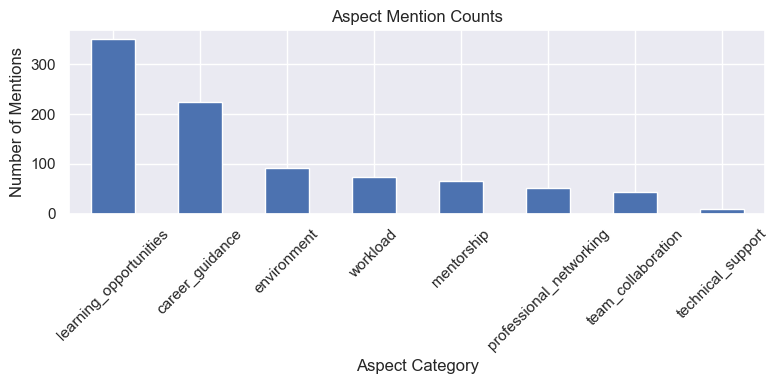

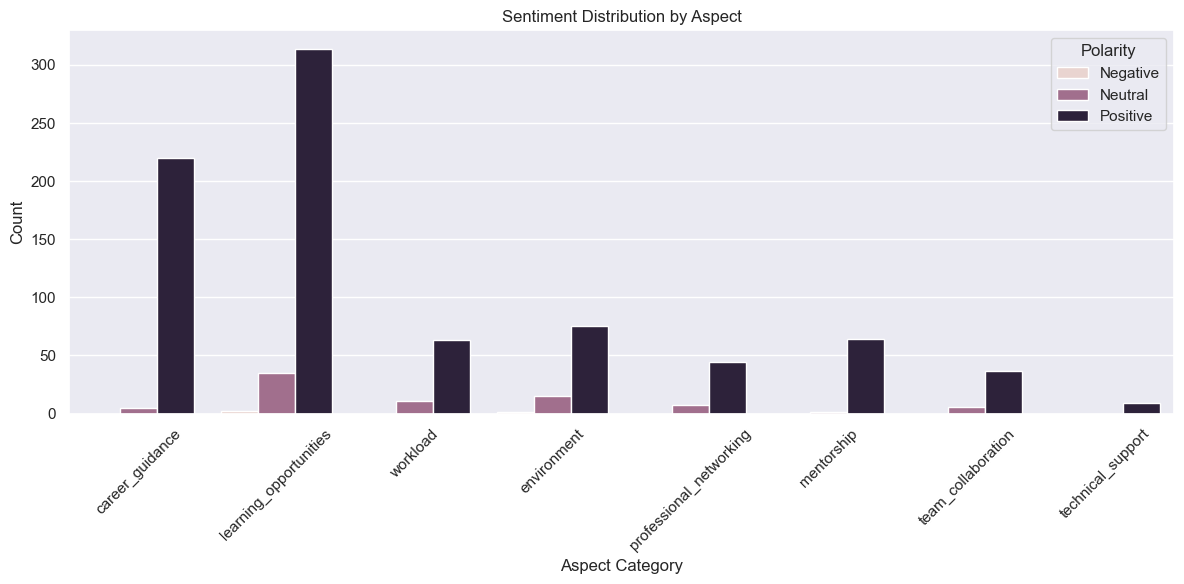

In [43]:
# 9.1 Aspect mention counts
plt.figure(figsize=(8,4))
absa_terms_df['aspect_category'].value_counts().plot(kind='bar')
plt.title('Aspect Mention Counts')
plt.xlabel('Aspect Category')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9.2 Sentiment distribution per aspect
plt.figure(figsize=(12,6))
sns.countplot(data=absa_terms_df, x='aspect_category', hue='polarity')
plt.title('Sentiment Distribution by Aspect')
plt.xlabel('Aspect Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Polarity', labels=['Negative', 'Neutral', 'Positive'])
plt.tight_layout()
plt.show()


## 10. Save Outputs & Models


In [44]:
# 10. Save ABSA Outputs & Ontology

from joblib import dump

# 10.1 Save the final aspect–sentiment DataFrame
absa_terms_df.to_excel("absa_aspect_sentiment.xlsx", index=False)

# 10.2 Persist your aspect ontology mapping
# (This is the term→category dict you’ve been using)
dump(term_to_cat, "models/term_to_cat.joblib")

# If you are using a HuggingFace model and want to save it, you could do:
# sent_pipe.model.save_pretrained("models/sentiment_model")
# sent_pipe.tokenizer.save_pretrained("models/sentiment_tokenizer")


['models/term_to_cat.joblib']

# --- SECTION 7: ABSA EVALUATION AGAINST GROUND TRUTH ---